In [0]:
!pip install https://github.com/fastai/fastai/archive/master.zip
#!pip install opencv-python
#!apt update && apt install -y libsm6 libxext6
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
  
#!pip3 install torchvision
#! pip install torchtext


In [0]:
! pip install fastai
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *


In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2018-07-29 22:43:55--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918269 (897K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 896.75K  1.33MB/s    in 0.7s    

2018-07-29 22:43:56 (1.33 MB/s) - ‘ml-latest-small.zip’ saved [918269/918269]



In [5]:
ls

datalab/  ml-latest-small.zip


In [8]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [9]:
!mkdir data
!unzip ml-latest-small.zip -d data/


Archive:  ml-latest-small.zip
   creating: data/ml-latest-small/
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/movies.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/tags.csv  


In [11]:
! cd data && ls

ml-latest-small


In [0]:
path='data/ml-latest-small/'

In [0]:
ratings= pd.read_csv(path+'ratings.csv')

In [15]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [16]:
movies=pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


##Collaborative filtering with fastai

In [0]:
val_idxs=get_cv_idxs(len(ratings))
wd=2e-4
n_factors=50# This is the depth of the embedding matrix. Can be thought of as the number of latent features. (see note above)


In [0]:
# Now declare our data and learner
# We pass in the two columns and the thing we want to predict
cf=CollabFilterDataset.from_csv(path,'ratings.csv','userId','movieId','rating')
learn=cf.get_learner(n_factors,val_idxs,64,opt_fn=optim.Adam)

In [23]:
#finding the best learning rate
learn.lr_find()

 75%|███████▍  | 934/1251 [00:08<00:02, 108.25it/s, loss=4.87]


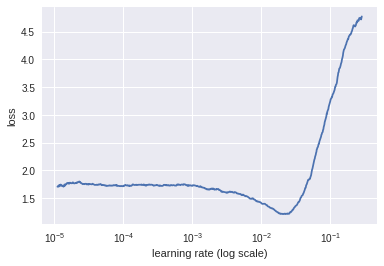

In [24]:
learn.sched.plot()

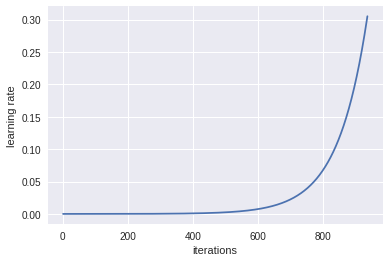

In [25]:
learn.sched.plot_lr()

In [26]:
learn.fit(0.00317,2,cycle_len=1,cycle_mult=2,wds=wd)

epoch      trn_loss   val_loss   
    0      0.909187   0.911769  
  8%|▊         | 97/1251 [00:01<00:12, 93.46it/s, loss=0.891]

    1      0.78697    0.784537  
    2      0.664381   0.773104  



[array([0.7731])]

**The evaluation method here is MSE -- mean squared error (sum of actual value-predicted value)^2/num of samples). So we'll take the square root to get our RMSE.**

In [27]:
math.sqrt(0.7731)

0.8792610533851707

In [0]:
preds=learn.predict()
y=learn.data.val_y

## Movie Bias

**Our bias affects the movie rating, so we can also think of it as a measure of how good/bad movies are.**

In [0]:
movie_names = movies.set_index('movieId')['title'].to_dict()


In [0]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]

In [50]:
topMovies

array([ 356,  296,  318, ...,  149, 1554,   72])

In [0]:
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])


**So below we have a model wth two embedding layers, and then two bias layers -- one of user biases, and one for item biases (in this case, items = movies).**


**You can see the 0th element is the number of items, and the 1st element is the number of features. For example, in our user embedding layer, we have 671 users and 50 features, in our item bias layer we have 9066 movies and 1 bias for each movie, etc.**

In [60]:
m=learn.model;m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

**Here we take our top movie IDs and pass them into the item bias layer to get the biases for the movie.**

**Note: PyTorch lets you do this -- pass in indices to a layer to get the corresponding values. The indicies must be converted to PyTorch Variables first. Recall that a variable is basically like a tensor that supports automatic differentiation.**

**We then convert the resulting data to a NumPy array so that work can be done on the CPU.**

In [0]:
movie_bias=to_np(m.ib(V(topMovieIdx)))

In [64]:
(movie_bias)

array([[ 0.81272],
       [ 0.96435],
       [ 1.26198],
       ...,
       [ 0.26417],
       [-0.05818],
       [ 0.25061]], dtype=float32)

In [0]:
# Zip up the movie names with their respective biases
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies, movie_bias)]

**Now we can look at top and bottom rated movies, corrected for reviewer sentiment, and the different types of movies viewers watch.**

**Below are bottom rated movies**


In [70]:
sorted(movie_ratings, key=lambda o: o[0])[:15]


[(-1.0009699, 'Battlefield Earth (2000)'),
 (-0.85735816, 'Wild Wild West (1999)'),
 (-0.8255412, 'Anaconda (1997)'),
 (-0.8109754, 'Super Mario Bros. (1993)'),
 (-0.8050425, 'Speed 2: Cruise Control (1997)'),
 (-0.7004428, 'Inspector Gadget (1999)'),
 (-0.69935024, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.69102156, 'Congo (1995)'),
 (-0.6802088, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.6641919, 'Batman & Robin (1997)'),
 (-0.64195544, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.6387304, 'Avengers, The (1998)'),
 (-0.6352769, 'Bio-Dome (1996)'),
 (-0.63259125, 'Superman III (1983)'),
 (-0.6322118, 'Jaws 3-D (1983)')]

**And these are top rated movies**

In [71]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]


[(1.2619832, 'Shawshank Redemption, The (1994)'),
 (1.2316613, 'Godfather, The (1972)'),
 (1.1097251, 'Usual Suspects, The (1995)'),
 (1.0758594, 'Godfather: Part II, The (1974)'),
 (0.9643454, 'Pulp Fiction (1994)'),
 (0.962297, "Schindler's List (1993)"),
 (0.9564319, 'Fargo (1996)'),
 (0.9285193, '12 Angry Men (1957)'),
 (0.9068303, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.90497094, 'American Beauty (1999)'),
 (0.8965753, 'Dark Knight, The (2008)'),
 (0.89168906, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.8842657, 'Silence of the Lambs, The (1991)'),
 (0.8713396, 'Stand by Me (1986)'),
 (0.8708245, 'Maltese Falcon, The (1941)')]

##Interpreting embedding matrices

In [77]:
movie_embeddings  = to_np(m.i(V(topMovieIdx)))
movie_embeddings.shape

(3000, 50)

**It's hard to interpret 50 different factors. We use Principle Component Analysis (PCA) to simplify them down to 3 vectors.**

**PCA essentially says, reduce our dimensionality down to n. It finds 3 linear combinations of our 50 embedding dimensions whic capture as much variation as possible, while also making those 3 linear combinations as different to each other as possible.**

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_embeddings.T).components_
movie_pca.shape


(3, 3000)

In [0]:
factor0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

In [85]:
# Looking at the first component, it looks like it's something like classier movies vs. more lighthearted
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07592221, 'Fargo (1996)'),
 (0.0735939, 'Pulp Fiction (1994)'),
 (0.06698744, 'Being John Malkovich (1999)'),
 (0.066247076, 'Chinatown (1974)'),
 (0.0631403, 'Three Colors: Red (Trois couleurs: Rouge) (1994)'),
 (0.06274937, 'Godfather, The (1972)'),
 (0.06060743, 'Taxi Driver (1976)'),
 (0.059274606, '2001: A Space Odyssey (1968)'),
 (0.05868421, 'Clockwork Orange, A (1971)'),
 (0.056030717, 'Goodfellas (1990)')]

In [89]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.07264546, 'Armageddon (1998)'),
 (-0.06624988, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.06616313, 'Bodyguard, The (1992)'),
 (-0.06277191, "Charlie's Angels (2000)"),
 (-0.06078386, 'Coyote Ugly (2000)'),
 (-0.05913431, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.05828667, 'Pearl Harbor (2001)'),
 (-0.057718895, 'Man in the Iron Mask, The (1998)'),
 (-0.056795377, 'Back to the Future Part II (1989)'),
 (-0.056456372, 'Titanic (1997)')]

In [0]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

In [96]:
# Looking at the second component, it looks like it's more like CGI vs Dialagoue driven
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.051107116, 'Psycho (1998)'),
 (0.050285026, 'Alien: Resurrection (1997)'),
 (0.04559891, 'Specialist, The (1994)'),
 (0.04539943, 'Coneheads (1993)'),
 (0.0441544, 'Battlefield Earth (2000)'),
 (0.043938845, 'English Patient, The (1996)'),
 (0.043726906, 'Leaving Las Vegas (1995)'),
 (0.043284774, 'American Psycho (2000)'),
 (0.043273125, 'Catwoman (2004)'),
 (0.04246684, 'Anaconda (1997)')]

In [97]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1197067, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.10851084, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.10751183, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.10429299,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.09963316, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.09837852, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.08933297, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.078764595, 'Untouchables, The (1987)'),
 (-0.07775646, 'Saving Private Ryan (1998)'),
 (-0.07673876, 'Matrix, The (1999)')]

In [0]:
fac2 = movie_pca[2]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac2, topMovies)]

In [102]:
# Looking at the thirdponent, it looks like it's more like Top rated vs low rated
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07165489, 'Mars Attacks! (1996)'),
 (0.0669004, 'American Pie (1999)'),
 (0.065995485, 'Clue (1985)'),
 (0.06419779, 'Man Who Knew Too Little, The (1997)'),
 (0.062836654, 'Scream (1996)'),
 (0.06268591, 'Eyes Wide Shut (1999)'),
 (0.06002538, 'Dogma (1999)'),
 (0.058604397, 'Barbarella (1968)'),
 (0.058573775, 'Scary Movie (2000)'),
 (0.055882514, 'True Lies (1994)')]

In [101]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.08154296, 'Aladdin (1992)'),
 (-0.06862062, 'Sound of Music, The (1965)'),
 (-0.06777711, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.067702234, 'Mission: Impossible II (2000)'),
 (-0.06219837, "Bug's Life, A (1998)"),
 (-0.06006081, 'Bend It Like Beckham (2002)'),
 (-0.059700493, "Schindler's List (1993)"),
 (-0.05899975, 'My Big Fat Greek Wedding (2002)'),
 (-0.058837052, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.057453893, 'Shawshank Redemption, The (1994)')]

**We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.**

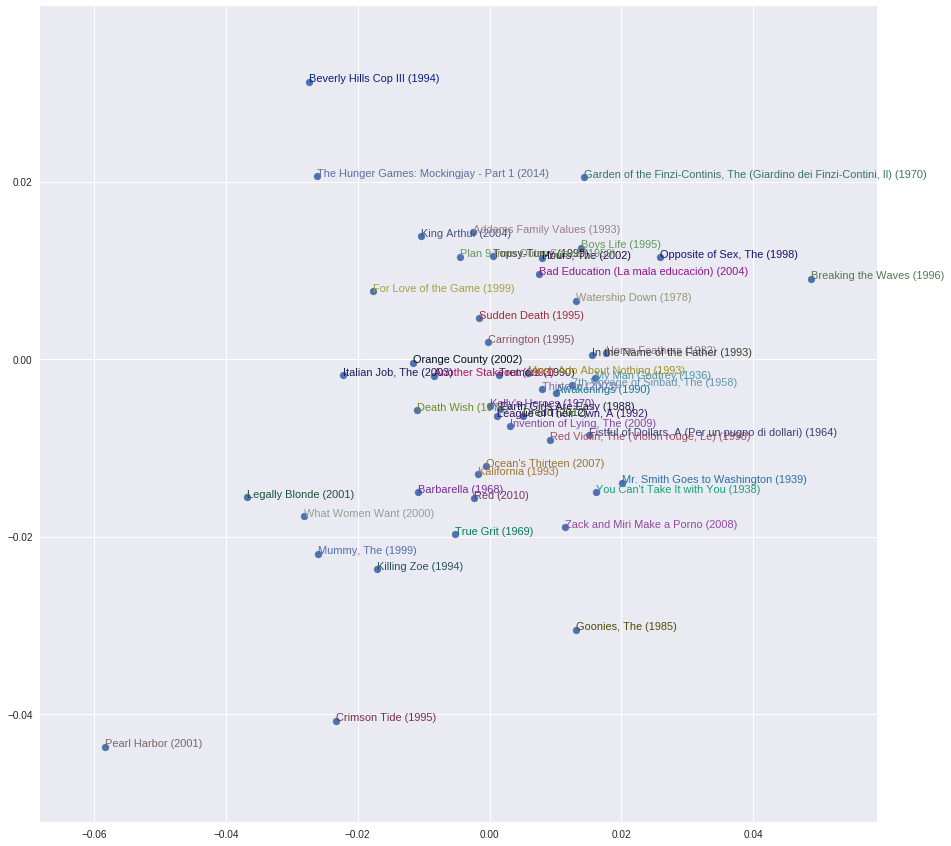

In [98]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

##End.